# MOM :

1. **Objetivos**

Análise numérica das propriedades de antenas tipo dipolos usando o Método dos Momentos.
<br/>
<br/>
2. **Geometria**

Seja uma antena de dipolo linear, de comprimento L, ao longo do eixo dos z, alimentada pelo centro. Considere que
o raio do fio a seja muito menor que o comprimento de onda, e que o metal da antena seja perfeitamente condutor.
<br/>
<br/>
3. **Prática**

    1. Seguindo o procedimento mostrado em sala, obtenha os elementos das matrizes de Impedância (Z) e de Tensão (V) para funções de base tipo triangulares.
    2. Implemente a formulação em Matlab ou outro ambitente/linguagem desejada.
    3. Para uma antena de meio comprimento-de-onda ($L = \lambda/2$), e raio $a = 10^{−4}\lambda$, determine a distribuiçãoo de corrente ao longo da antena. Use 19 funções de base. Varie o número de funçõess de base (N) e observe a convergência.
    4. Para a antena do item anterior, obtenha a impedância de entrada, e mostre sua convergência com N.
    5. Repita o item 3 para uma antena de 1 comprimento-de-onda ($L = \lambda$).
    6. Para a antena de ($L = \lambda$), obtenha a impedância de entrada, e mostre sua variação com N.


In [6]:
#Import
import scipy.constants as sci
import numpy as np
import matplotlib.pyplot as pl
import math
from mpl_toolkits.mplot3d import Axes3D 

from matplotlib import cm
from numpy.linalg import inv
from scipy.linalg import toeplitz

In [7]:
#define constants
#E0 = sci.epsilon_0
#U0 = sci.mu_0
Clight = sci.speed_of_light
Freq = 299792458.0 #Hz
Lambda = Clight/Freq
Pi = math.pi
k0 = 2*Pi/Lambda
#k = k0*math.sqrt(E0*U0)

In [8]:
''' Define Voltage Array, that will be in column form
Recieve the Number of segments
'''
def voltageColumn(N,V0):
    V = np.zeros((N,1),dtype=np.complex_)
    if(N%2==0):
        temp = int(N/2)
        V[temp] = V0;
        V[temp-1]= V0;
    else:
        temp = int((N-1)/2)
        V[temp] = V0
    return V


In [9]:
def funcZ(x,L,N):
    Delta = L/(N+1)
    if(x < 0):
        x = 0
    return -L/2 + x*Delta

In [10]:
def funcPsi(m,n, L, N,a):
    Delta = L/(N+1)
    if(m == n):
        fst = 1./(2*Pi*Delta)
        snd = np.log((Delta/2 + np.sqrt( (Delta/2)**2 + a**2  ) ) /a )
        third = 1j*k0/4*Pi
        return fst*snd - third
    else:
        fst = np.sqrt( (funcZ(m,L,N) - funcZ(n,L,N))**2 + a**2 )
        snd = np.exp(-1j*k0*fst)
        third = 4*Pi
        return snd/(third*fst)

In [11]:
def funcAmn(m,n,L,N,a):
    Delta = L/(N+1)
    return (Delta**2)*funcPsi(m,n,L,N,a)

In [12]:
def funcPhi(m,n,L,N,a):
    fst = funcPsi(m-1/2 , n-1/2,L,N,a)
    snd = funcPsi(m+1/2 , n-1/2,L,N,a)
    thd = funcPsi(m-1/2 , n+1/2,L,N,a)
    qrt = funcPsi(m+1/2 , n+1/2,L,N,a)
    return (fst - snd - thd + qrt)

In [13]:
def impedanceMtz(L,N,a):
    Zmn = np.empty([N,N], dtype=np.complex_)
    ZmnAux = np.zeros((1,N), dtype=np.complex_)
    for i in range(0,N):
        for j in range (0,N):
            Zmn[i][j] = (k0**2)*funcAmn(i+1,j+1,L,N,a) - funcPhi(i+1,j+1,L,N,a)
    for i in range(0,N):
        ZmnAux[0][i] = (k0**2)*funcAmn(1,i+1,L,N,a) - funcPhi(1,i+1,L,N,a)
    return Zmn, ZmnAux
            

## Current Approach

***

In [107]:
def currentDist(L,N,a, V0):
    Zmtz, Zaux = impedanceMtz(L,N,a)
    Zaux = toeplitz(Zaux)
    ZauxInv = inv(Zaux)
    ZInv = inv(Zmtz)
    Vin = voltageColumn(N,V0)
    Imnaux = np.dot(ZauxInv,Vin)
    Imn = np.dot(ZInv,Vin)
    
    return Imn, np.arange(0,N)

In [108]:
def plotCurrentDist(L,N,a, V0, strL):
    Imn, vec_N = currentDist(L,N,a,V0)
    pl.plot(vec_N, abs(Imn))
    pl.xlabel('Segmentos')
    pl.ylabel('Corrente (Magnitude)')
    pl.title('Distribuição de Corrente para L =' + strL)

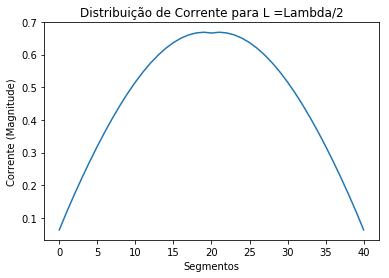

In [109]:
plotCurrentDist(Lambda/2, 41 , Lambda*(10**(-4)), 1, "Lambda/2")

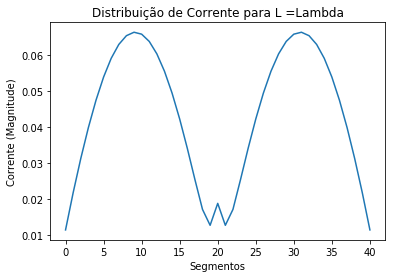

In [110]:
plotCurrentDist(Lambda, 41 , Lambda*(10**(-4)),1, "Lambda")

In [102]:
def entryCurrent(L,N,a,V0):
    Zmtz, Zaux = impedanceMtz(L,N,a)
    Zaux = toeplitz(Zaux)
    ZauxInv = inv(Zaux)
    ZInv = inv(Zmtz)
    Vin = voltageColumn(N,V0)
    Imnaux = np.dot(ZauxInv,Vin)
    Imn = np.dot(ZInv,Vin)
    return Imn[int((N-1)/2)]

In [103]:
def allCurrent(itr,L,a,V0):
    list_convert = []
    for i in range(3,itr,4):
        list_convert.append( entryCurrent(L,i,a,V0) )
    return np.array(list_convert,dtype=np.complex_), np.arange(3,itr,4)

In [104]:
def plotAllCurrent(itr,L,a,V0,strL):
    test_vec1, test_vec2 = allCurrent(itr,L, a, V0 )
    # Points
    pl.plot(test_vec2, abs(test_vec1), linestyle='--', marker='o', color='b')

    # Show the major grid lines with dark grey lines
    # pl.grid(b=True, linestyle="-", color='black', which='major')

    # Show the minor grid lines with very faint and almost transparent grey lines
    pl.minorticks_on()
    pl.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.5)

    pl.xlabel('Segmentos')
    pl.ylabel('Corrent (A)')
    pl.title('Convergência da Corrente para L = ' + strL)

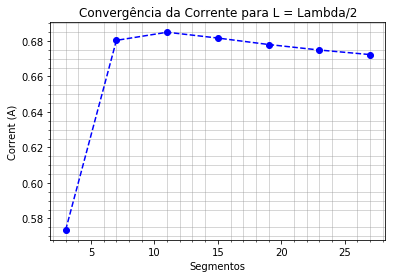

In [105]:
plotAllCurrent(30,Lambda/2, Lambda*(10**(-4)), 1 , "Lambda/2")

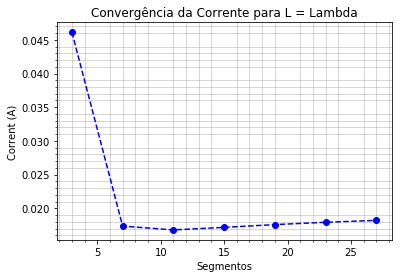

In [106]:
plotAllCurrent(30,Lambda, Lambda*(10**(-4)), 1 , "Lambda")

## Impedance Approach

***

In [59]:
def entryImpedance(L,N,a,V0):
    Zmtz, Zaux = impedanceMtz(L,N,a)
    Zaux = toeplitz(Zaux)
    ZauxInv = inv(Zaux)
    ZInv = inv(Zmtz)
    Vin = voltageColumn(N,V0)
    Imnaux = np.dot(ZauxInv,Vin)
    Imn = np.dot(ZInv,Vin)
    return Vin[int((N-1)/2)]/Imn[int((N-1)/2)]

In [91]:
def allImpedance(itr,L,a,V0):
    list_convert = []
    for i in range(3,itr,4):
        list_convert.append( entryImpedance(L,i,a,V0) )
        
    return np.array(list_convert, dtype=np.complex_), np.arange(3,itr,4)

In [95]:
def plotAllImpedance(itr, L,a,V0, strL):
    test_vec1, test_vec2 = allImpedance(itr,L, a, V0 )
    # Points
    pl.plot(test_vec2, abs(test_vec1), linestyle='--', marker='o', color='b')

    # Show the major grid lines with dark grey lines
#     pl.grid(b=True, linestyle="-", color='black', which='major')

    # Show the minor grid lines with very faint and almost transparent grey lines
    pl.minorticks_on()
    pl.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.5)

    pl.xlabel('Segmentos')
    pl.ylabel('Resistência (ohms)')
    pl.title('Convergência da Resistência para L = ' + strL)
    

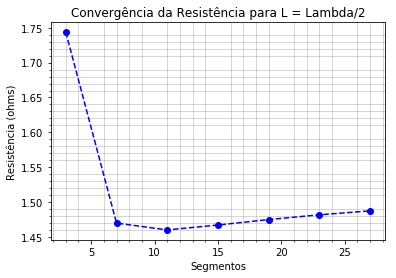

In [96]:
plotAllImpedance(30,Lambda/2, Lambda*(10**(-4)), 1 , "Lambda/2")

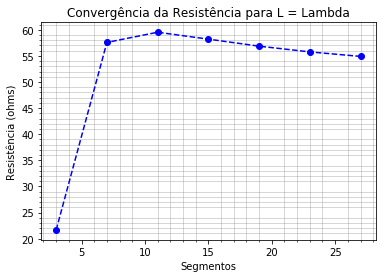

In [111]:
plotAllImpedance(30,Lambda, Lambda*(10**(-4)), 1 ,"Lambda")

TypeError: entryImpedance() missing 2 required positional arguments: 'a' and 'V0'